In [1]:
# Notebook configuration

RESULTS_DIR = "./results"

In [20]:
# Python imports

import os
import json
import re

import pandas as pd
from matplotlib import pyplot
import numpy as np

In [25]:
# Accumulate results jsons
jsons = []

# locate a .json files in the results data dir
for root, dir, files in os.walk(RESULTS_DIR):
    for file in files:
        
        if file.endswith(".json"):
            fpath = os.path.join(root, file)
            #if fpath.find("sv7-apu11")<0:
            #    continue
            #if fpath.find("deep-10M")<0:
            #    continue
            jsons.append(fpath)

print(jsons)

['./results/h5py/fractals-1/jbenson/weaviate_benchmark__deep-image-96-angular.hdf5__128__32.json', './results/h5py/fractals-1/jbenson/weaviate_benchmark__deep-20M.hdf5__64__16.json', './results/h5py/fractals-1/jbenson/weaviate_benchmark__deep-image-96-angular.hdf5__64__32.json', './results/h5py/fractals-1/jbenson/weaviate_benchmark__deep-image-96-angular.hdf5__128__16.json', './results/h5py/fractals-1/jbenson/weaviate_benchmark__deep-20M.hdf5__64__32.json', './results/h5py/fractals-1/jbenson/weaviate_benchmark__deep-image-96-angular.hdf5__64__16.json', './results/h5py/sv7-apu12/sho/weaviate_benchmark__gist-960-euclidean.hdf5__128__16.json', './results/h5py/sv7-apu12/sho/weaviate_benchmark__gist-960-euclidean.hdf5__64__16.json', './results/h5py/sv7-apu12/sho/weaviate_benchmark__gist-960-euclidean.hdf5__128__32.json', './results/h5py/sv7-apu12/sho/weaviate_benchmark__gist-960-euclidean.hdf5__64__32.json', './results/h5py/sv7-apu12/gwilliams/weaviate_benchmark__deep-10M.hdf5__64__16.json'

In [36]:
# Load into one dataframe

rows = []

for jsonfile in jsons:
    f = open(jsonfile)
    objs = json.load(f)
    f.close()

    #print(jsonfile, objs[0].keys())
    for obj in objs:
        row = {}
        row['benchmarkFile'] = obj['benchmarkFile']
        row['distanceMetric'] = obj['distanceMetric']
        row['totalTested'] = obj['totalTested']
        row['maxConnections'] = obj['maxConnections']
        row['ef'] = obj['ef']
        row['efConstruction'] = obj['efConstruction']
        row['recall_10'] = obj['recall']['10']['average']
        row['latency_mean'] = obj['requestTimes']['limit_10']['latencies']['mean']
        row['latency_p90'] = obj['requestTimes']['limit_10']['latencies']['p90']
        row['latency_p95'] = obj['requestTimes']['limit_10']['latencies']['p95']
        row['latency_p99'] = obj['requestTimes']['limit_10']['latencies']['p99']     
        row['totalDatasetSize'] = obj['totalDatasetSize']
        row['importTime'] = obj['importTime']
        row['wallImportTime'] = obj['wallImportTime'] \
            if 'wallImportTime' in obj.keys() else np.NAN

        rows.append(row)

df = pd.DataFrame(rows)
#print(df)
        

In [37]:
# Augment with various columns

regex = re.compile("deep-(\d+)[MK].hdf5")

def get_dset(row):
    matches = regex.match(row['benchmarkFile'])
    if matches:
        return 'Deep-1B'
    else:
        return "Unknown"

df['dataset'] = df.apply( lambda row: get_dset(row), axis=1 )

        

In [46]:
# Show the data

pd.reset_option('display.max_rows')
pd.set_option('display.max_rows', None)
df


,benchmarkFile,distanceMetric,totalTested,maxConnections,ef,efConstruction,recall_10,latency_mean,latency_p90,latency_p95,latency_p99,totalDatasetSize,importTime,wallImportTime,dataset
0,deep-image-96-angular.hdf5,cosine,10000,32,64,128,9.6482,11183967,19270845,22993911,32508833,9990000,3980,NaN,Unknown
1,deep-image-96-angular.hdf5,cosine,10000,32,128,128,9.7434,11642302,18911357,21898754,32450466,9990000,3980,NaN,Unknown
2,deep-image-96-angular.hdf5,cosine,10000,32,256,128,9.9030,14055824,20108693,23105788,50726023,9990000,3980,NaN,Unknown
3,deep-image-96-angular.hdf5,cosine,10000,32,512,128,9.9665,18749911,25518121,28351246,39131624,9990000,3980,NaN,Unknown
4,deep-20M.hdf5,cosine,1000,16,64,64,9.0690,7773298,12909067,14676059,18660333,20000000,8867,NaN,Deep-1B
5,deep-20M.hdf5,cosine,1000,16,128,64,9.2700,6854200,11620309,12594236,16543132,20000000,8867,NaN,Deep-1B
6,deep-20M.hdf5,cosine,1000,16,256,64,9.6140,6701248,10139612,12126656,13976162,20000000,8867,NaN,Deep-1B
7,deep-20M.hdf5,cosine,1000,16,512,64,9.7890,9028555,12190027,13982100,18646477,20000000,8867,NaN,Deep-1B
8,deep-image-96-angular.hdf5,cosine,10000,32,64,64,9.4041,10249666,19661668,24670547,50746161,9990000,3976,NaN,Unknown
9,deep-image-96-angular.hdf5,cosine,10000,32,128,64,9.5442,11125479,18728746,22529618,32126039,9990000,3976,NaN,Unknown


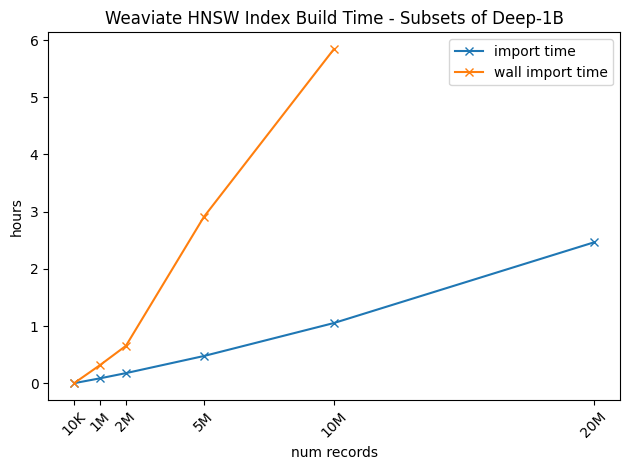

In [49]:
# Visualize import time for Deep-1B subsets

# compute average import time via groupby
df_import_time = df [ df['dataset']=='Deep-1B' ] \
    [ ['dataset', 'totalDatasetSize', 'importTime' ] ]
avg_import_time = \
    df_import_time.groupby( [ 'dataset', 'totalDatasetSize' ] )\
        ['importTime'].mean()

# compute average wall import time via groupby
df_wall = df[df['wallImportTime'].notnull()] # note that not all rows have wallImportTime
df_wall_import_time = df_wall [ df_wall['dataset']=='Deep-1B' ] \
    [ ['dataset', 'totalDatasetSize', 'wallImportTime' ] ]
avg_wall_import_time = \
    df_wall_import_time.groupby( [ 'dataset', 'totalDatasetSize' ] )\
        ['wallImportTime'].mean()

# get the plot points for import time
xs = []
ys = []
for idx in avg_import_time.index:
    x = idx[1]
    xs.append(x)
    y = avg_import_time[idx]/(60.0*60.0)
    ys.append(y)
#print(xs,ys)

# get the plot points for wall import time
wxs = []
wys = []
for idx in avg_wall_import_time.index:
    x = idx[1]
    wxs.append(x)
    y = avg_wall_import_time[idx]/(60.0*60.0)
    wys.append(y)
#print(wxs,wys)

# plot the lines and label the plot
fig, ax = pyplot.subplots()
ax.plot(xs,ys, marker='x', label="import time")
ax.plot(wxs,wys, marker='x', label="wall import time")
ax.set_ylabel('hours')
ax.set_xlabel('num records')
ax.set_xticks(xs)
ax.set_xticklabels(['10K','1M','2M','5M','10M','20M'], rotation = 45)
ax.set_title("Weaviate HNSW Index Build Time - Subsets of Deep-1B")
ax.legend(loc='best')
fig.tight_layout()
fig.savefig("results/weaviate_hnsw_build_time.png")

# TODO:  plot the variance at each X

Index(['benchmarkFile', 'distanceMetric', 'totalTested', 'maxConnections', 'ef', 'efConstruction', 'recall_10', 'latency_mean', 'latency_p90', 'latency_p95', 'latency_p99', 'totalDatasetSize', 'importTime', 'wallImportTime', 'dataset'], dtype='object')
[20000000 10000000    10000  5000000  1000000  2000000]
                                               recall_10                 latency_mean                       latency_p95                    
                                                    mean    min     max          mean       min       max          mean       min       max
totalDatasetSize efConstruction maxConnections                                                                                             
10000            64             16              9.990375  9.977  10.000  4.044210e+06   2840174   5358283  8.262421e+06   4731404  11601778
                                32              9.993750  9.983  10.000  3.500176e+06   2829495   4507486  6.327508e+06   4671401  

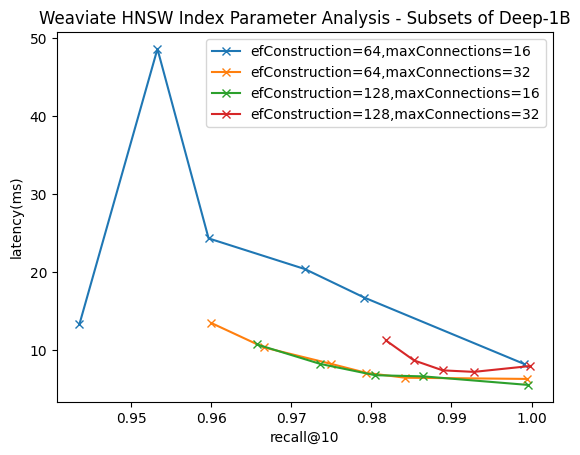

In [71]:
# Visualize the recall vs search latency for Deep-1B parameter groups

print(df.columns)

# get Deep-1B rows
df_recall_latency = df [ df['dataset']=='Deep-1B' ] \
    [ ['dataset', 'benchmarkFile', 'totalDatasetSize', \
       'efConstruction', 'maxConnections', \
       'recall_10', 'latency_mean', 'latency_p95' ] ]

# get dataset sizes for Deep-1B so fara
dset_sizes = df[ df['dataset']=='Deep-1B' ]['totalDatasetSize'].unique()
print(dset_sizes)

# list the different build parameter groups of interest - (efConstruction, maxConnections)
param_groups = [ (64,16), (64,32), (128,16), (128,32) ]

recall_latency_grp = df[ df['dataset']=='Deep-1B' ]\
    .groupby(['totalDatasetSize','efConstruction','maxConnections']) \
        .agg( \
        {'recall_10':['mean','min','max'],
         'latency_mean':['mean','min','max'],
         'latency_p95':['mean','min','max']})

pd.reset_option('display.width')
pd.set_option('display.width', 1000)
print(recall_latency_grp)

#raise Exception("stop")

# extract plot points for each parameter group by dataset size
all_lines = {}
for pg in param_groups:
    # get df with those parameters
    _df = df_recall_latency[ \
        (df_recall_latency['efConstruction']==pg[0]) &
        (df_recall_latency['maxConnections']==pg[1]) ]
    #print(_df)
    # get the mean recall and latency
    recall_latency = _df.groupby(['totalDatasetSize']) \
        .mean(['recall_10','p95_latency'])
    print(recall_latency.index)
    recall = list(recall_latency['recall_10'])
    recall = [ rc/10.0 for rc in recall ]
    latency = list(recall_latency['latency_p95'])
    latency = [ lt/1000000.0 for lt in latency ]
    print(recall, latency)

    all_lines[ pg ] = ( recall, latency )


# plot the lines and label the plot
fig, ax = pyplot.subplots()
for ln in all_lines.keys():
    xs = all_lines[ln][0]
    ys = all_lines[ln][1]
    ax.plot(xs,ys, marker='x',label="efConstruction=%d,maxConnections=%d" % (ln[0],ln[1]))

ax.legend(loc='best')
ax.set_xlabel('recall@10')
ax.set_ylabel('latency(ms)')

ax.set_title("Weaviate HNSW Index Parameter Analysis - Subsets of Deep-1B")
fig.savefig("results/weaviate_index_parm_analysis.png")